In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats.mstats import winsorize

In [7]:
# Opt in to future behavior to avoid downcasting warnings
pd.set_option('future.no_silent_downcasting', True)
INPUT_FILE = 'masked_kiva_loans.csv'
OUTPUT_FILE = 'kiva_loans_cleaned_ml_ready.csv'

In [8]:
print("Loading data...")
df = pd.read_csv(INPUT_FILE, low_memory=False)
print(f"Initial shape: {df.shape}\n")

Loading data...
Initial shape: (33561, 11)



In [9]:
# 1. Initial Assessment
print("Initial missing values:")
print(df.isnull().sum().sort_values(ascending=False)[:10], "\n")


Initial missing values:
partner_id            634
borrower_genders      195
id                      0
loan_amount             0
funded_amount           0
country                 0
sector                  0
term_in_months          0
lender_count            0
repayment_interval      0
dtype: int64 



# 3. Data Cleaning
# 3.1 Drop duplicate rows if any

In [10]:
print("Dropping duplicates...")
prev_size = len(df)
df.drop_duplicates(inplace=True)
print(f"Removed {prev_size - len(df)} duplicates\n")

Dropping duplicates...
Removed 0 duplicates



In [11]:
# 3. Column Selection (Keep only relevant columns)
keep_cols = [
    'id', 'funded_amount', 'loan_amount', 'sector', 'country',
    'partner_id', 'term_in_months', 'lender_count', 'borrower_genders',
    'repayment_interval', 'date'
]
df = df[keep_cols]

# 3.2 Handle missing values
# - If columns have too many missing values, consider dropping
# - Otherwise impute or fill

In [12]:
print("Handling missing values:")

Handling missing values:


#  Process borrower_genders column: count number of female and male

In [13]:
# Convert to lowercase and handle missing values
df['borrower_genders'] = df['borrower_genders'].str.lower().fillna('unknown')

# Split genders into a list
genders = df['borrower_genders'].str.split(',')

# Count females and males
df['female_count'] = genders.apply(lambda x: x.count('female') if isinstance(x, list) else 0)
df['male_count'] = genders.apply(lambda x: x.count('male') if isinstance(x, list) else 0)

# Total borrowers
df['total_borrowers'] = df['female_count'] + df['male_count']

In [14]:
# After creating the new columns
df = df.drop(columns=['borrower_genders'])

# For numerical columns, fill with median

In [15]:
num_cols = ['funded_amount', 'loan_amount', 'term_in_months', 'lender_count']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
    # Convert to appropriate numeric types
    if col in ['lender_count', 'term_in_months']:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    else:
        df[col] = pd.to_numeric(df[col], downcast='float')

# For categorical columns, fill with mode

In [16]:
cat_cols = ['sector', 'country', 'repayment_interval']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0]).astype('category')

# 3.3 Convert date columns

In [17]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[~df['date'].isna()]  # Remove rows with invalid dates

# 3.4 Remove or cap outliers (example using quantiles)

In [18]:
df['partner_id'].duplicated().sum()

np.int64(33279)

<Axes: ylabel='lender_count'>

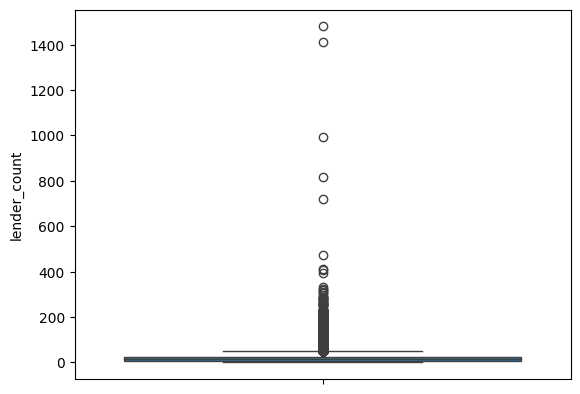

In [19]:
sns.boxplot(df['lender_count'])

In [20]:
Q1 = df['funded_amount'].quantile(0.25)
Q3 = df['funded_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['funded_amount'] < lower_bound) | (df['funded_amount'] > upper_bound)]
df['funded_amount'] = np.where(df['funded_amount'] > upper_bound, upper_bound, df['funded_amount'])
df['funded_amount'] = np.where(df['funded_amount'] < lower_bound, lower_bound, df['funded_amount'])


In [21]:
q1 = df['loan_amount'].quantile(0.25)
q3 = df['loan_amount'].quantile(0.75)
iqr = q3 - q1
lowerbound = q1 - 1.5 * iqr
upperbound = q3 + 1.5 * iqr

outlier = df[(df['loan_amount'] < lowerbound) | (df['loan_amount'] > upperbound)]
df['loan_amount'] = np.where(df['loan_amount'] > upperbound, upperbound, df['loan_amount'])
df['loan_amount'] = np.where(df['loan_amount'] < lowerbound, lowerbound, df['loan_amount'])

<Axes: ylabel='funded_amount'>

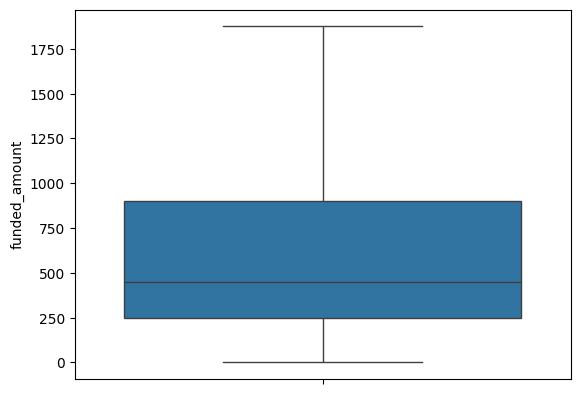

In [22]:
sns.boxplot(df['funded_amount'])

<Axes: ylabel='loan_amount'>

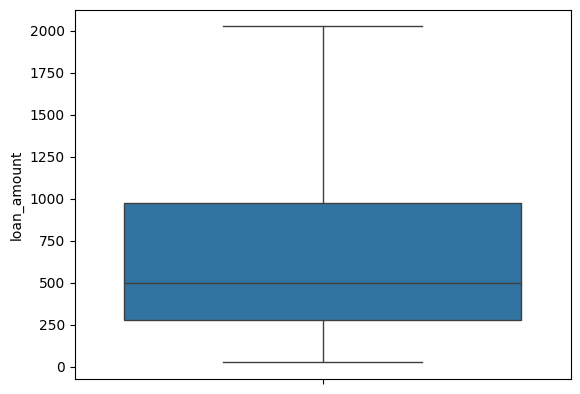

In [23]:
sns.boxplot(df['loan_amount'])

# 4. Data Transformation
# 4.1 Feature engineering: extract date parts

In [24]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['date'].dt.to_period('M')

In [25]:
df['funding_ratio'] = df['funded_amount'] / df['loan_amount'].replace(0, np.nan)
df['amount_per_lender'] = df['funded_amount'] / df['lender_count'].replace(0, np.nan)

In [26]:
# Gender features
df['female_only'] = (df['female_count'] > 0) & (df['male_count'] == 0)
df['male_only'] = (df['male_count'] > 0) & (df['female_count'] == 0)
df['mixed_gender'] = (df['female_count'] > 0) & (df['male_count'] > 0)

# 5. Final Exploration

In [27]:
# 7. Final Validation
print("\nFinal validation:")
print(f"Final shape: {df.shape}")
print("Missing values check:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Final validation:
Final shape: (33561, 21)
Missing values check:
partner_id           634
amount_per_lender    152
dtype: int64


In [28]:
# Check data types
print("\nData types:")
print(df.dtypes)


Data types:
id                             int64
funded_amount                float64
loan_amount                  float64
sector                      category
country                     category
partner_id                   float64
term_in_months                 int16
lender_count                   int16
repayment_interval          category
date                  datetime64[ns]
female_count                   int64
male_count                     int64
total_borrowers                int64
year                           int32
month                          int32
year_month                 period[M]
funding_ratio                float64
amount_per_lender            float64
female_only                     bool
male_only                       bool
mixed_gender                    bool
dtype: object


In [29]:
# Basic stats
print("\nNumerical columns summary:")
print(df[num_cols].describe())


Numerical columns summary:
       funded_amount   loan_amount  term_in_months  lender_count
count    33561.00000  33561.000000    33561.000000  33561.000000
mean       642.65889    691.773934       13.691428     20.549179
std        525.92744    567.818345        8.566574     28.514324
min          0.00000     25.000000        1.000000      0.000000
25%        250.00000    275.000000        8.000000      7.000000
50%        450.00000    500.000000       13.000000     13.000000
75%        900.00000    975.000000       14.000000     24.000000
max       1875.00000   2025.000000      145.000000   1481.000000


# 6. Save cleaned data

In [31]:
df.to_csv('kiva_clean_powerbi.csv', index=False)
print("Final shape:", df.shape)
print("Data cleaned and saved as 'kiva_loans_cleaned_final.csv'.")

Final shape: (33561, 21)
Data cleaned and saved as 'kiva_loans_cleaned_final.csv'.
